# 2D Data generation and WNN architectures for training

In [1]:
import time
import numpy as np
import nmrglue as ng
import MRAi_2D as ma
import Proc_2D as pr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})

2024-10-01 05:44:01.512441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 05:44:04.922709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Training Scheme

![Trainig.png](Figs/Training.png)

### 1D WNN Architecture
This section generates the 1D WNN architecture used for training on Non-Uniform Sampling (NUS) data reconstruction. A nearly identical architecture is also used for Virtual Decoupling tasks.
![WNN_1D.png](Figs/WNN_1D.png)

In [2]:
%%time
# Create a model
WNN_1D = ma.wnn.WNN_1D(Size=128,sliding_window=3,filter=20,LR=0.004)

# Print a useful summary of the model
WNN_1D.summary()

2024-09-27 02:59:19.616005: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-27 02:59:19.616083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37709 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-09-27 02:59:19.617564: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-27 02:59:19.617587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38237 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-09-27 02:59:19.618936: W tensorflow/core/

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 255, 3)]             0         []                            
                                                                                                  
 tf.concat (TFOpLambda)      (None, 510, 3)               0         ['input_1[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 510, 1, 3)            0         ['tf.concat[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 509, 1, 20)           140       ['reshape[0][0]']         

### 2D WNN Architecture
This section generates the 2D WNN architecture used for training on Echo data reconstruction.

![WNN_2D.png](Figs/WNN_2D.png)

In [4]:
%%time
# Create a model
WNN_2D = ma.wnn.WNN_2D(Size=32,filter=50,LR=0.0001)

# Print a useful summary of the model
WNN_2D.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 63, 127)]         0         
                                                                 
 reshape_4 (Reshape)         (None, 63, 127, 1)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 124, 50)       450       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 62, 124, 50)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 120, 50)       10050     
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 60, 120, 50)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 112, 50)       1005

### 2D WNN Uncertaity Architecture
This section generates the 2D WNN architecture used for training on uncertainty estimation.
![Un.png](Figs/Un.png)

In [5]:
%%time
# Create a model
WNN_2D_Un= ma.wnn.WNN_2D_Uncertainty(Size=32,filter=50,LR=0.001)

# Print a useful summary of the model
WNN_2D_Un[0].summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 63, 127)]            0         []                            
                                                                                                  
 reshape_6 (Reshape)         (None, 63, 127, 1)           0         ['input_4[0][0]']             
                                                                                                  
 conv2d_23 (Conv2D)          (None, 62, 124, 50)          450       ['reshape_6[0][0]']           
                                                                                                  
 tf.nn.relu_4 (TFOpLambda)   (None, 62, 124, 50)          0         ['conv2d_23[0][0]']           
                                                                                            

### 2D US spectrum generator

The 2D NMR hyper-complex time-domain signal, known as the Free Induction Decay (FID), can be represented as a superposition of several 2D exponential functions:

$$\mathbf{X}_{\text{FID}}(t_1, t_2) = \sum_{n=1}^{N} A_n \left( e^{i(2\pi \omega_{1n} t_1 + \phi_{1n})} e^{-t_1 / \tau_{1n}} \right) \left( e^{i(2\pi \omega_{2n} t_2 + \phi_{2n})} e^{-t_2 / \tau_{2n}} \right)$$

where the sum is over $N$ exponentials, and the $n$-th exponential has:

- Number of peaks: $N$
- Amplitude: $A_n$
- Frequencies: $\omega_{1n}$ (indirect dimension), $\omega_{2n}$ (direct dimension)
- Relaxation times: $\tau_{1n}$ (indirect dimension), $\tau_{2n}$ (direct dimension)
- Phases: $\phi_{1n}$ (indirect dimension), $\phi_{2n}$ (direct dimension)

The evolution times $t_1$ and $t_2$ range from $0$ to $T - 1$, where $T$ is the number of complex points in each dimension. By randomly varying the above parameters, the desired number of different FIDs can be simulated. Gaussian noise is added to emulate the noise present in realistic NMR spectra. Subsequently, standard 2D signal processing by the Python package nmrglue, including apodization, zero-filling, FT, and phase correction, are employed to obtain pure absorption mode spectrum from the hypercomplex $\mathbf{X}_\text{FID}$ in 2D NMRPipe format.

![Generator.png](Figs/Generator.png)

In [2]:
%%time
# These parameters have been used for the generation of "Spectra/Data.ft2"

# Number of complex points in each dimension [t1 points, t2 points]
T = np.array([128,2048])
# Total number of peaks
N = 2048
# Amplitude range
a_range = np.array([0.05,1])
# Frequency range (normalized frequencies)
omega_range = np.array([-0.49,0.49])
# Relaxation time ranges for t1 and t2 dimensions
tau_range = np.array([
    [0.1/T[0],0.5/T[0]],    # tau range for t1
    [2.0/T[1],10./T[1]]     # tau range for t2
    ])
# Phase range 
phi_range = np.array([0,1])*np.pi/180
# NMRPipe Processing Using Weighting Functions:
# 0: for t1 and t2 and 1: for just t2
MODE = 0
# Signal-to-noise ratio
SNR = 1000
# Seed for generation
np.random.seed(50)
# Generate a Uniform Sampling spectrum using a dictionary (dic) file in NMRPipe format
dic, US = pr.pipe_generator.data_Full(T,N,a_range,omega_range,tau_range,phi_range,SNR,MODE)

CPU times: user 4.11 s, sys: 9.3 ms, total: 4.12 s
Wall time: 4.11 s


### Convert Uniform Sampling (US) to Non-Uniform Sampling (NUS)
To convert Uniform Sampling (US) data to Non-Uniform Sampling (NUS), a NUS table is required.

![US_NUS.png](Figs/US_NUS.png)

In [5]:
%%time
# This function generates a NUS table based on either Poisson Gap sampling ("PG") or Flat Random sampling ("FR").
# In the example below, the NUS table is generated using Poisson Gap ("PG") sampling for a dataset with 25% NUS points.
NUS_table = pr.NUS_sampler.NS(N_of_point=32,N_signal_point=T[0],kind='PG')
# Convert US to NUS with NUS table
NUS = pr.convertors.US_to_NUS(US,NUS_table)


CPU times: user 14.8 ms, sys: 7.68 ms, total: 22.5 ms
Wall time: 21.5 ms


### Convert Uniform Sampling (US) to Echo

![US_Echo.png](Figs/US_Echo.png)

In [6]:
%%time
# Convert US to Echo
Echo = pr.convertors.VE_to_E(US)

CPU times: user 98.5 ms, sys: 7.57 ms, total: 106 ms
Wall time: 104 ms


### Convert Uniform Sampling (US) to Anti-Echo

![US_Anti.png](Figs/US_Anti.png)

In [7]:
%%time
# Convert US to Anti
Anti = pr.convertors.VE_to_AE(US)

CPU times: user 108 ms, sys: 3.86 ms, total: 112 ms
Wall time: 110 ms


### Plotting the spectra.

CPU times: user 1.31 s, sys: 20.1 ms, total: 1.33 s
Wall time: 1.32 s


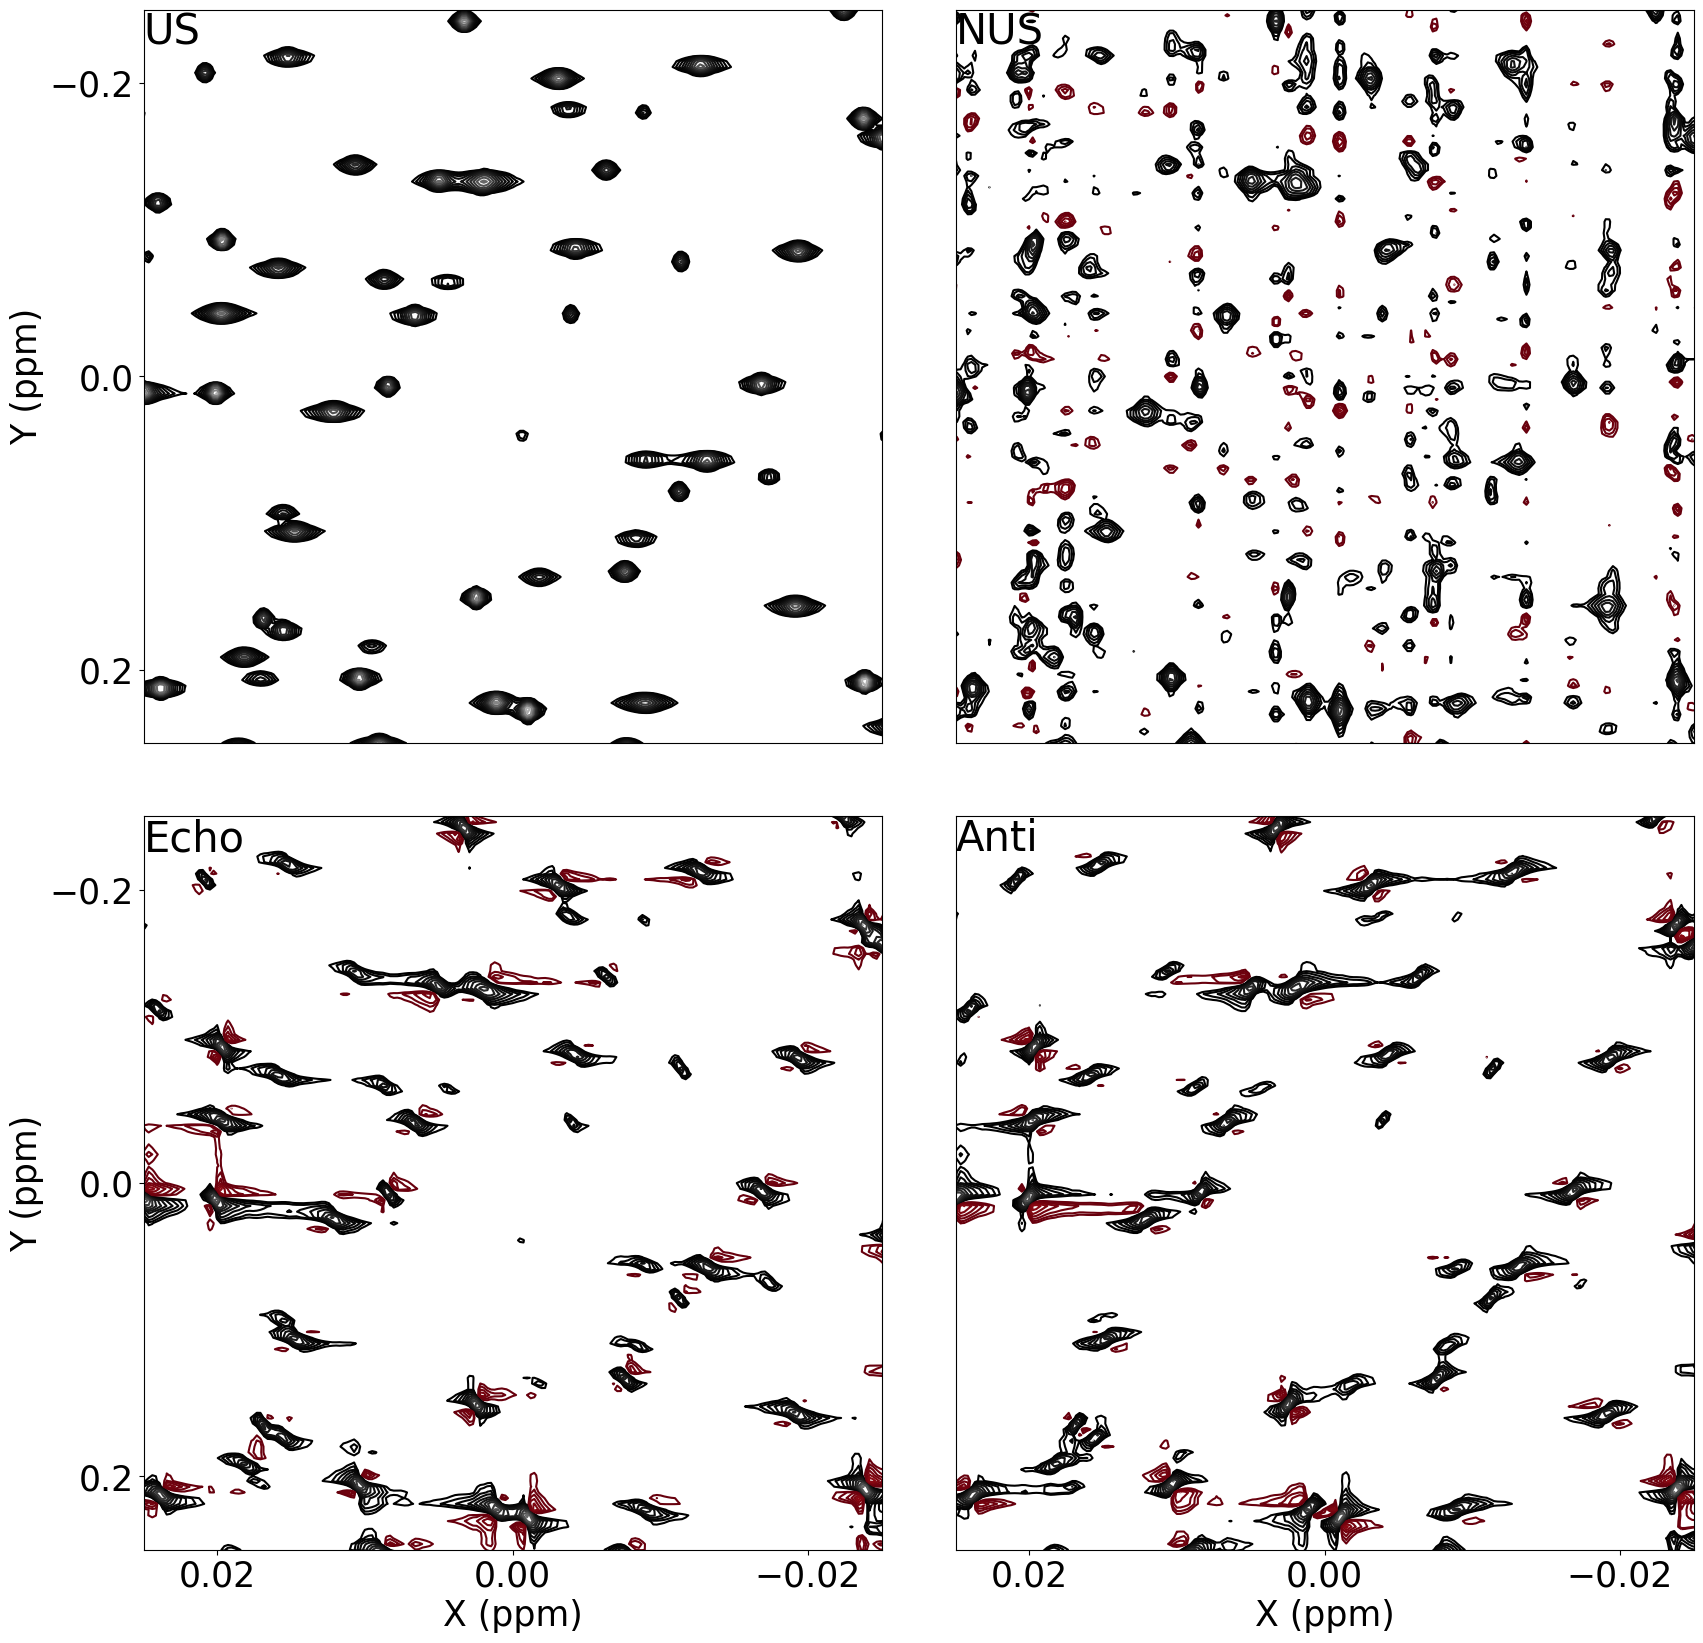

In [14]:
%%time

fig, ax = plt.subplots(2,2,figsize=(2*10,2*10))
cmap = [plt.cm.Greys_r,plt.cm.Reds_r]       #[+,-] contour map (colors to use for contours)
contour = [0.025,1.3,15]                     #[contour level start value, scaling factor between contour level]
lim = [0.025,-0.025,0.25,-0.25]                    #[xlim from,xlim to,ylim from,ylim to]

pr.PLOTS.subp(ax[0,0],dic,US/np.max(US), "US",contour,cmap,lim)
pr.PLOTS.subp(ax[0,1],dic,NUS/np.max(US), "NUS",contour,cmap,lim)
pr.PLOTS.subp(ax[1,0],dic,Echo/np.max(US), "Echo",contour,cmap,lim)
pr.PLOTS.subp(ax[1,1],dic,Anti/np.max(US), "Anti",contour,cmap,lim)

ax[0,0].axes.xaxis.set_visible(False)
ax[0,1].axes.xaxis.set_visible(False)
ax[0,1].axes.yaxis.set_visible(False)
ax[1,1].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)